In [12]:
# !pip install emd
# !pip install umap-learn
# !pip install scikit-dimension
# !pip install neurodsp

In [1]:
# Load required libraries
import numpy as np
from scipy.io import loadmat
from scipy.signal import hilbert
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
from neurodsp.filt import filter_signal, filter_signal_fir, design_fir_filter
import emd
import pandas as pd
from sklearn.preprocessing import Normalizer
from tqdm import tqdm
import plotly.express as px
import copy
import umap.umap_ as umap
import skdim
from scipy.spatial import cKDTree
import pickle

# Import custom functions
from functions import *

sns.set(style='white', context='notebook')

In [2]:
from structure_index import compute_structure_index, draw_graph

# Load Data

In [3]:
with open('all_orn_data.pkl', 'rb') as file:
    orn_data = pickle.load(file)

In [4]:
orn_data.keys()

dict_keys(['ORN1_trials', 'ORN1_waveforms', 'ORN3_trials', 'ORN3_waveforms', 'ORN4_trials', 'ORN4_waveforms', 'ORN6_trials', 'ORN6_waveforms', 'ORN13_trials', 'ORN13_waveforms'])

In [5]:
orn1_waveforms = orn_data['ORN1_waveforms']
orn1_trials = orn_data['ORN1_trials']
orn3_waveforms = orn_data['ORN3_waveforms']
orn3_trials = orn_data['ORN3_trials']
orn4_waveforms = orn_data['ORN4_waveforms']
orn4_trials = orn_data['ORN4_trials']
orn6_waveforms = orn_data['ORN6_waveforms']
orn6_trials = orn_data['ORN6_trials']
orn13_waveforms = orn_data['ORN13_waveforms']
orn13_trials = orn_data['ORN13_trials']

# Intrinsic Dimension and UMAP embeddings

In [10]:
ID = np.round(np.nanmean(abids(orn1_waveforms, 50)))
ID

4.0

In [6]:
umap_embedder = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=4, metric='euclidean', random_state=42)
embedding = umap_embedder.fit(orn1_waveforms)
emb_orn1 = embedding.embedding_

umap_embedder = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=4, metric='euclidean', random_state=42)
embedding = umap_embedder.fit(orn3_waveforms)
emb_orn3 = embedding.embedding_

umap_embedder = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=4, metric='euclidean', random_state=42)
embedding = umap_embedder.fit(orn4_waveforms)
emb_orn4 = embedding.embedding_

umap_embedder = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=4, metric='euclidean', random_state=42)
embedding = umap_embedder.fit(orn6_waveforms)
emb_orn6 = embedding.embedding_

umap_embedder = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=4, metric='euclidean', random_state=42)
embedding = umap_embedder.fit(orn13_waveforms)
emb_orn13 = embedding.embedding_

# Alignment

In [7]:
params = {
    'n_bins': 20,
    'n_neighbors': 15,
    'discrete_label': False,
    'num_shuffles': 10,
    'verbose': False,
}

SI_orn1, binLabel_orn1, overlapMat_orn1, sSI_orn1 = compute_structure_index(emb_orn1, np.array(orn1_trials['peak_values']), **params)
SI_orn4, binLabel_orn4, overlapMat_orn4, sSI_orn4 = compute_structure_index(emb_orn4, np.array(orn4_trials['peak_values']), **params)

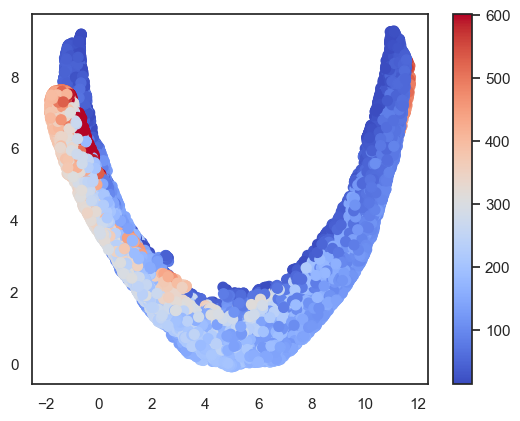

In [396]:
plt.scatter(emb_orn1[:,0], emb_orn1[:,1], c=orn1_trials['peak_values'],
            vmin=np.percentile(orn1_trials['peak_values'],1),
            vmax=np.percentile(orn1_trials['peak_values'],99),
            cmap='coolwarm', s=50)
plt.scatter(emb_orn4[:,0], emb_orn4[:,1], c=orn4_trials['peak_values'],
            vmin=np.percentile(orn4_trials['peak_values'],1),
            vmax=np.percentile(orn4_trials['peak_values'],99),
            cmap='coolwarm', s=50)
plt.colorbar();

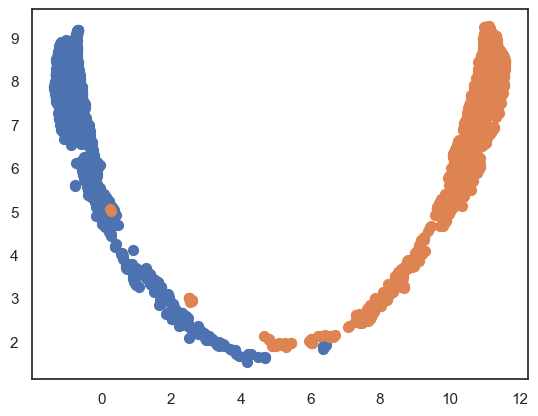

In [9]:
# Bin plot
bin = 0
plt.scatter(emb_orn1[binLabel_orn1[0] == bin,0], emb_orn1[binLabel_orn1[0] == bin,1], s=50);
plt.scatter(emb_orn4[binLabel_orn4[0] == bin,0], emb_orn4[binLabel_orn4[0] == bin,1], s=50);

In [10]:
centroids_orn1 = []
for i in range(20):
    centroid = np.mean(emb_orn1[binLabel_orn1[0] == i], axis=0)
    centroids_orn1.append(centroid)
centroids_orn1 = np.array(centroids_orn1)

centroids_orn4 = []
for i in range(20):
    centroid = np.mean(emb_orn4[binLabel_orn4[0] == i], axis=0)
    centroids_orn4.append(centroid)
centroids_orn4 = np.array(centroids_orn4)

In [11]:
np.random.seed(42)

min_size = min(len(emb_orn1[binLabel_orn1[0] == bin,0]), len(emb_orn4[binLabel_orn4[0] == bin,0]))
random_indexes = np.random.choice(range(len(emb_orn1[binLabel_orn1[0] == bin,0])), replace=False, size=min_size)
first_emb = emb_orn1[binLabel_orn1[0] == bin][random_indexes]
first_center = centroids_orn1[bin]

random_indexes = np.random.choice(range(len(emb_orn4[binLabel_orn4[0] == bin,0])), replace=False, size=min_size)
second_emb = emb_orn4[binLabel_orn4[0] == bin][random_indexes]
second_center = centroids_orn4[bin]

## ====================================

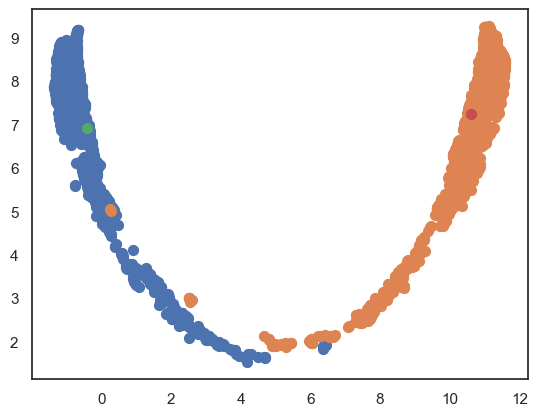

In [12]:
plt.scatter(first_emb[:,0], first_emb[:,1], s=50);
plt.scatter(second_emb[:,0], second_emb[:,1], s=50);

plt.scatter(first_center[0], first_center[1], s=50);
plt.scatter(second_center[0], second_center[1], s=50);

In [13]:
H = np.dot(first_emb.T, second_emb)
U, S, Vh = np.linalg.svd(H, full_matrices=True)

R = np.dot(U, Vh)
if np.linalg.det(R) < 0:
    Vh[3, :] = Vh[3, :] * (-1)
    R = np.dot(U, Vh)
print(np.linalg.det(R))

1.0


In [14]:
T = second_emb - np.dot(first_emb, R)

In [15]:
# Aligning 1 to be close to 4
new_emb = np.dot(first_emb, R)+ T

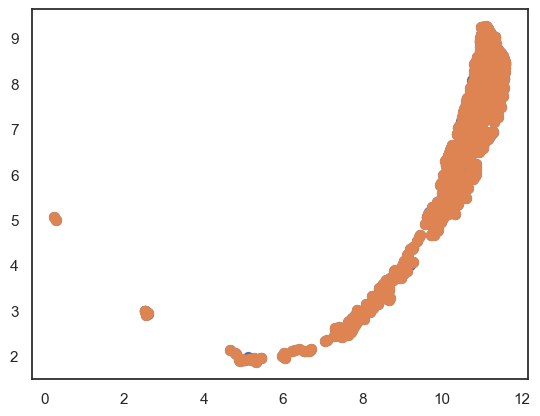

In [16]:
plt.scatter(emb_orn4[binLabel_orn4[0] == bin,0], emb_orn4[binLabel_orn4[0] == bin,1], s=50);
plt.scatter(new_emb[:,0], new_emb[:,1], s=50);

In [24]:
orn4_trials.iloc[binLabel_orn4[0] == bin]

,index,is_good,duration_samples,peak2trough,asc2desc,max_amp,trough_values,peak_values,mean_if,max_if,...,90,91,92,93,94,95,96,97,98,99
5,13,1,1531,0.475568,0.488354,52.894010,-42.307194,47.498186,1.633827,3.307333,...,-27.717417,-25.154637,-22.443935,-19.607026,-16.668138,-13.653510,-10.592660,-7.517042,-4.461456,-1.463925
7,15,1,854,0.630599,0.512941,59.521195,-24.604338,50.892874,2.930983,7.002713,...,-8.316892,-7.430073,-6.547528,-5.668852,-4.793469,-3.920670,-3.049721,-2.179458,-1.308829,-0.436821
8,16,1,790,0.397428,0.496082,78.591780,-72.864898,27.447188,3.161755,6.998059,...,-43.921965,-39.853848,-35.598674,-31.177108,-26.611774,-21.925653,-17.142547,-12.287213,-7.384952,-2.461523
11,19,1,834,0.389583,0.461371,75.315606,-55.395961,17.742814,2.998154,5.323092,...,-38.463362,-35.250645,-31.799150,-28.123804,-24.241015,-20.168042,-15.923311,-11.526384,-6.996790,-2.355744
14,25,1,1016,0.616034,0.437742,57.161525,-23.360923,43.120281,2.460701,5.449299,...,-8.511527,-7.543370,-6.588174,-5.648190,-4.725446,-3.820830,-2.935912,-2.071045,-1.226969,-0.403770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9162,14660,1,666,0.482206,0.511527,59.995910,-30.992814,48.838071,3.753313,4.075555,...,-13.919697,-12.427031,-10.922833,-9.414398,-7.908944,-6.413657,-4.935696,-3.482144,-2.059940,-0.675779
9169,14675,1,728,0.402391,0.464118,85.607906,-67.719552,36.520651,3.431716,4.698420,...,-44.656474,-40.818845,-36.731423,-32.410575,-27.874371,-23.142055,-18.233881,-13.172088,-7.979876,-2.681360
9180,14692,1,717,0.653041,0.483468,59.187916,-15.279888,56.651209,3.484595,6.764392,...,-9.074915,-8.395921,-7.664116,-6.874632,-6.022677,-5.103894,-4.112536,-3.043883,-1.892548,-0.653580
9181,14693,1,820,0.649403,0.514197,57.439900,-32.232444,51.791783,3.047335,6.058476,...,-17.365962,-15.929774,-14.414354,-12.814094,-11.125294,-9.342074,-7.459250,-5.470513,-3.370720,-1.153724


In [31]:
orn1_trials.iloc[binLabel_orn1[0] == bin]

,index,is_good,duration_samples,peak2trough,asc2desc,max_amp,trough_values,peak_values,mean_if,max_if,...,90,91,92,93,94,95,96,97,98,99
1,2,1,817,0.486685,0.472428,135.644429,-87.063017,58.600625,3.059675,3.461831,...,-63.867486,-59.006583,-53.672944,-47.875965,-41.626575,-34.939250,-27.832377,-20.327441,-12.449542,-4.228669
4,5,1,872,0.548948,0.495442,74.146697,-60.298726,38.647919,2.865991,3.427340,...,-38.181774,-34.879888,-31.383215,-27.700030,-23.841866,-19.819569,-15.643375,-11.326371,-6.880930,-2.319635
7,8,1,783,0.365698,0.494255,77.751734,-75.525573,31.469398,3.191517,5.383866,...,-43.442473,-39.238305,-34.885954,-30.409407,-25.833956,-21.184390,-16.485474,-11.761716,-7.037158,-2.335296
8,9,1,1141,0.440835,0.488397,92.125693,-87.134597,62.570858,2.190587,2.546616,...,-51.729761,-46.774199,-41.619408,-36.297739,-30.842721,-25.288221,-19.669401,-14.021185,-8.378425,-2.775712
11,14,1,866,0.456246,0.560866,82.040822,-73.261451,50.793749,2.891040,9.372788,...,-16.220646,-13.019393,-10.125378,-7.579970,-5.414582,-3.651650,-2.291092,-1.302630,-0.622266,-0.166939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7738,13351,1,732,0.490439,0.510970,137.562391,-71.179904,31.084398,3.414177,6.934819,...,-60.250676,-56.341571,-51.815223,-46.678926,-40.946598,-34.637493,-27.780365,-20.408798,-12.560942,-4.283803
7769,13398,1,752,0.512052,0.486687,89.040816,-29.748842,49.537780,3.326245,9.401192,...,-27.214964,-25.807441,-24.059359,-21.962806,-19.515158,-16.717300,-13.574765,-10.096168,-6.292239,-2.174017
7772,13401,1,864,0.360803,0.522982,192.725608,-190.613643,70.058170,2.892276,4.782518,...,-100.485690,-89.564687,-78.474118,-67.313261,-56.182729,-45.184203,-34.418347,-23.985484,-13.984140,-4.509988
7775,13406,1,868,0.397728,0.526533,122.664136,-120.296647,45.775719,2.871296,21.592478,...,-68.282040,-61.627254,-54.746081,-47.677973,-40.463388,-33.143154,-25.758652,-18.351227,-10.961920,-3.631097


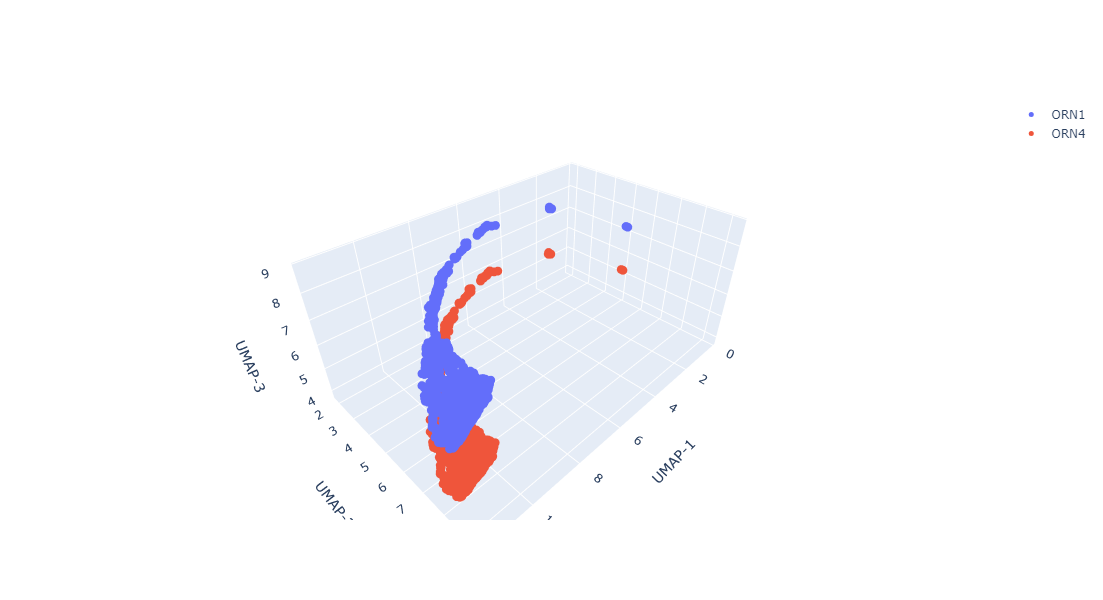

In [44]:
from plotly.graph_objs.layout import Scene
from plotly.graph_objs.layout.scene import XAxis, YAxis, ZAxis
import plotly.graph_objects as go

scatter1 = go.Scatter3d(
    x=new_emb[:, 0],
    y=new_emb[:, 1],
    z=new_emb[:, 2]+2,
    mode='markers',
    marker=dict(
        size=5,
        colorscale='Viridis',
    ),
    name='ORN1'
)

scatter2 = go.Scatter3d(
    x=emb_orn4[binLabel_orn4[0] == bin, 0],
    y=emb_orn4[binLabel_orn4[0] == bin, 1],
    z=emb_orn4[binLabel_orn4[0] == bin, 2],
    mode='markers',
    marker=dict(
        size=5,
        colorscale='Viridis',
    ),
    name='ORN4'
)

# Combine both scatter plots into a single figure
fig = go.Figure(data=[scatter1, scatter2])

# Update the layout of the figure
fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    scene=dict(
        xaxis=dict(title='UMAP-1'),
        yaxis=dict(title='UMAP-2'),
        zaxis=dict(title='UMAP-3')
    )
)

# Show the figure
fig.show()

# Align all centroids

In [533]:
params = {
    'n_bins': 20,
    'n_neighbors': 15,
    'discrete_label': False,
    'num_shuffles': 10,
    'verbose': False,
}

SI_orn1, binLabel_orn1, overlapMat_orn1, sSI_orn1 = compute_structure_index(emb_orn1, np.array(orn1_trials['peak_values']), **params)
SI_orn4, binLabel_orn4, overlapMat_orn4, sSI_orn4 = compute_structure_index(emb_orn4, np.array(orn4_trials['peak_values']), **params)

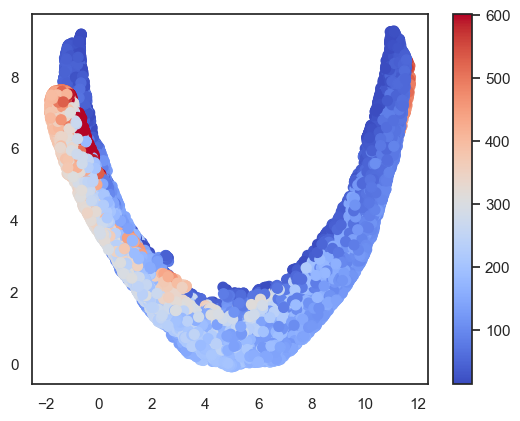

In [534]:
plt.scatter(emb_orn1[:,0], emb_orn1[:,1], c=orn1_trials['peak_values'],
            vmin=np.percentile(orn1_trials['peak_values'],1),
            vmax=np.percentile(orn1_trials['peak_values'],99),
            cmap='coolwarm', s=50)
plt.scatter(emb_orn4[:,0], emb_orn4[:,1], c=orn4_trials['peak_values'],
            vmin=np.percentile(orn4_trials['peak_values'],1),
            vmax=np.percentile(orn4_trials['peak_values'],99),
            cmap='coolwarm', s=50)
plt.colorbar();

In [543]:
centroids_orn1 = []
for i in range(20):
    centroid = np.mean(emb_orn1[binLabel_orn1[0] == i], axis=0)
    centroids_orn1.append(centroid)
centroids_orn1 = np.array(centroids_orn1)

centroids_orn4 = []
for i in range(20):
    centroid = np.mean(emb_orn4[binLabel_orn4[0] == i], axis=0)
    centroids_orn4.append(centroid)
centroids_orn4 = np.array(centroids_orn4)

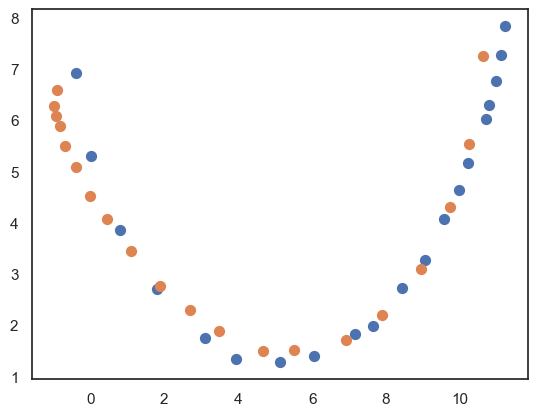

In [544]:
plt.scatter(centroids_orn1[:,0], centroids_orn1[:,1], s=50);
plt.scatter(centroids_orn4[:,0], centroids_orn4[:,1], s=50);

In [546]:
H = np.dot(centroids_orn4.T, centroids_orn1)
U, S, Vh = np.linalg.svd(H, full_matrices=True)

R = np.dot(U, Vh)
if np.linalg.det(R) < 0:
    Vh[3, :] = Vh[3, :] * (-1)
    R = np.dot(U, Vh)
print(np.linalg.det(R))

1.0


In [569]:
T = centroids_orn4 - np.dot(centroids_orn1, R)

In [568]:
centroids_orn4[0]

array([10.615398 ,  7.247895 ,  5.251313 ,  5.3778725], dtype=float32)

In [567]:
np.dot(centroids_orn1, R)[0]

array([8.008917 , 4.694196 , 2.3680801, 4.0269346], dtype=float32)

In [570]:
T

array([[ 2.6064816 ,  2.5536985 ,  2.883233  ,  1.3509378 ],
       [ 1.8708515 ,  2.6744637 ,  0.9317653 ,  0.44698763],
       [ 1.9000654 ,  2.8238204 , -0.3762467 , -0.18943024],
       [ 2.1486683 ,  2.534721  , -1.1736712 , -0.7888212 ],
       [ 2.4268389 ,  2.2451353 , -1.7130616 , -1.2202749 ],
       [ 2.1849713 ,  2.01443   , -2.0743268 , -1.4253893 ],
       [ 1.8539429 ,  1.5790255 , -2.1317701 , -1.8390021 ],
       [ 1.7670097 ,  1.2261462 , -2.4509215 , -2.2039819 ],
       [ 1.4109495 ,  0.9470916 , -2.5710235 , -2.3766308 ],
       [ 0.8299366 ,  1.1570642 , -2.9943295 , -2.38351   ],
       [ 0.34467113,  0.768371  , -3.214746  , -2.7977762 ],
       [-0.25287402,  0.83604455, -3.7142653 , -2.9918523 ],
       [-0.95016825,  0.6458919 , -4.0295825 , -3.4859452 ],
       [-1.4580593 ,  0.5234604 , -4.4620347 , -3.9755044 ],
       [-2.0506954 ,  0.6132107 , -5.087045  , -4.2813888 ],
       [-2.4262254 ,  0.17407846, -5.5595713 , -5.051197  ],
       [-2.89039   ,  0.

In [562]:
new_emb = np.dot(centroids_orn1, R)# + T

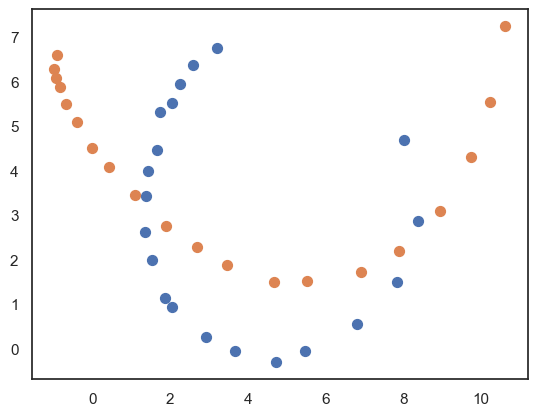

In [563]:
plt.scatter(new_emb[:,0], new_emb[:,1], s=50);
plt.scatter(centroids_orn4[:,0], centroids_orn4[:,1], s=50);